# 训练你的物体检测器

In [2]:
!pip install gluoncv

    100% |████████████████████████████████| 512kB 12.9MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 33.1MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluoncv as gcv
import mxnet as mx

# 准备训练集

In [4]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['juice', 'cocacola', 'cocacola-zero']
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('images/train')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['juice', 'cocacola', 'cocacola-zero']
num_images: 5


# 可视化数据

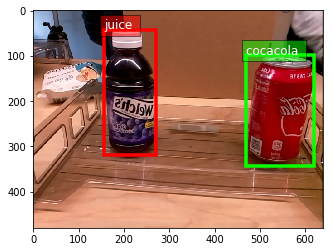

In [5]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()


# 定义训练过程

In [6]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
    ctx = mx.gpu(0)
    net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=train_dataset.classes, transfer='coco')
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height)
    gcv.utils.random.seed(233)
    
    batch_size = 4
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width), ctx))
    anchors = anchors.as_in_context(mx.cpu())
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
    batchify_fn = Tuple(Stack(), Stack(), Stack())
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    mbox_loss = gcv.loss.SSDMultiBoxLoss()
    ce_metric = mx.metric.Loss('CrossEntropy')
    smoothl1_metric = mx.metric.Loss('SmoothL1')
    for k, v in net.collect_params().items():
        if 'convpredictor' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            cls_targets = mx.gluon.utils.split_and_load(batch[1], ctx_list=[ctx], batch_axis=0)
            box_targets = mx.gluon.utils.split_and_load(batch[2], ctx_list=[ctx], batch_axis=0)
            
            with autograd.record():
                cls_preds = []
                box_preds = []
                for x in data:
                    cls_pred, box_pred, _ = net(x)
                    cls_preds.append(cls_pred)
                    box_preds.append(box_pred)
                sum_loss, cls_loss, box_loss = mbox_loss(
                    cls_preds, box_preds, cls_targets, box_targets)
                autograd.backward(sum_loss)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(1)
            ce_metric.update(0, [l * batch_size for l in cls_loss])
            smoothl1_metric.update(0, [l * batch_size for l in box_loss])
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
            btic = time.time()
    return net
        


# 开始训练

In [7]:
epochs = 20
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

Model file is not found. Downloading.


181189KB [00:03, 56830.25KB/s]                            


[Epoch 0][Batch 0], Speed: 0.548 samples/sec, CrossEntropy=10.671, SmoothL1=0.188
[Epoch 1][Batch 0], Speed: 6.716 samples/sec, CrossEntropy=10.069, SmoothL1=0.170
[Epoch 2][Batch 0], Speed: 9.457 samples/sec, CrossEntropy=9.347, SmoothL1=0.169
[Epoch 3][Batch 0], Speed: 2.703 samples/sec, CrossEntropy=9.115, SmoothL1=0.175
[Epoch 3][Batch 1], Speed: 90.115 samples/sec, CrossEntropy=8.844, SmoothL1=0.279
[Epoch 4][Batch 0], Speed: 5.027 samples/sec, CrossEntropy=8.506, SmoothL1=0.298
[Epoch 5][Batch 0], Speed: 3.883 samples/sec, CrossEntropy=8.344, SmoothL1=0.280
[Epoch 6][Batch 0], Speed: 3.270 samples/sec, CrossEntropy=8.072, SmoothL1=0.274
[Epoch 7][Batch 0], Speed: 7.088 samples/sec, CrossEntropy=7.875, SmoothL1=0.259
[Epoch 7][Batch 1], Speed: 91.295 samples/sec, CrossEntropy=7.648, SmoothL1=0.268
[Epoch 8][Batch 0], Speed: 4.966 samples/sec, CrossEntropy=7.448, SmoothL1=0.283
[Epoch 9][Batch 0], Speed: 5.377 samples/sec, CrossEntropy=7.221, SmoothL1=0.265
[Epoch 10][Batch 0], Spe